## Part1 Cluster Code

#### Merge Dataset 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# read data and set missing value to 'nan' value
gdp_df = pd.read_csv(r"gdp_per_capita_yearly_growth.csv", usecols=["country", "2018"],
                         keep_default_na=False, na_values=[""])
income_df = pd.read_csv(r"income_per_person.csv", usecols=["country", "2018"],
                         keep_default_na=False, na_values=[""])
industry_percent_df = pd.read_csv(r"industry_percent_of_gdp.csv", usecols=["country", "2018"],
                         keep_default_na=False, na_values=[""])
inflation_df = pd.read_csv(r"inflation_annual_percent.csv", usecols=["country", "2018"],
                         keep_default_na=False, na_values=[""])
life_exp_df = pd.read_csv(r"life_expectancy_years.csv", usecols=["country", "2018"],
                         keep_default_na=False, na_values=[""])

# rename new columns
gdp_df.rename(columns={'2018':'gdp_per_cap'}, inplace=True)
income_df.rename(columns={'2018':'income_per_cap'}, inplace=True)
industry_percent_df.rename(columns={'2018':'industry_percent'}, inplace=True)
inflation_df.rename(columns={'2018':'inflation'}, inplace=True)
life_exp_df.rename(columns={'2018':'life_exp'}, inplace=True)

# merge all colums into one dataset 
merged_inner1 = pd.merge(gdp_df, income_df, on='country')
merged_inner2 = pd.merge(merged_inner1, industry_percent_df, on='country')
merged_inner3 = pd.merge(merged_inner2, inflation_df, on='country')
merged_total= pd.merge(merged_inner3, life_exp_df, on='country')

# to see data summary
print("The shape of final dataset is:", merged_total.shape)
# to see data description
merged_total.describe()

The shape of final dataset is: (185, 6)


,gdp_per_cap,income_per_cap,industry_percent,inflation,life_exp
count,179.000000,185.000000,160.000000,179.000000,182.000000
mean,2.913517,18263.151351,26.429875,5.288489,72.996703
std,2.137532,19457.397557,11.599308,7.208205,6.998555
min,-10.100000,629.000000,2.380000,-2.850000,52.400000
25%,1.685000,3820.000000,19.100000,1.530000,68.100000
50%,2.790000,12000.000000,25.350000,2.840000,74.200000
75%,3.835000,26400.000000,31.625000,5.825000,78.375000
max,14.600000,113000.000000,66.200000,47.200000,85.000000


#### Data Cleaning - Replace missing value to mean 

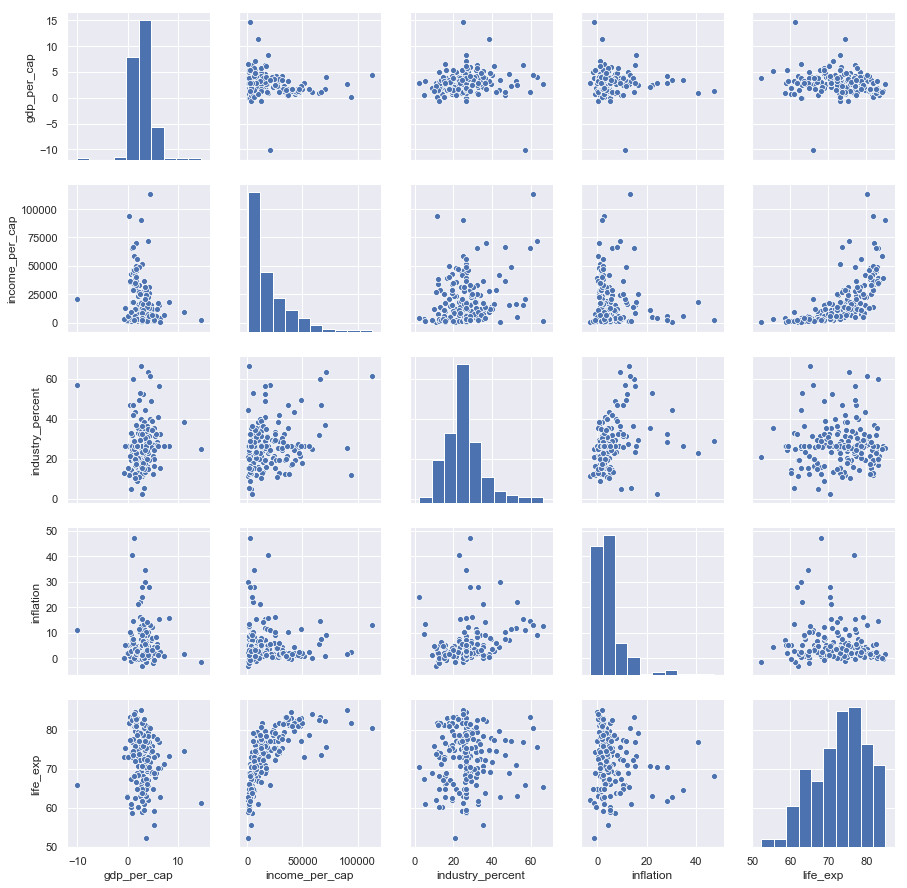

In [3]:
import numpy as np
# import imputer module from Scikit-learn and instantiate imputer object
from sklearn.preprocessing import Imputer
# replce nan value to mean
imputer = Imputer(missing_values=np.nan, strategy='mean')

# define columns to impute on
cols = ['gdp_per_cap',
         'income_per_cap',
         'industry_percent',
         'inflation',
         'life_exp']

# fit imputer and transform dataset, store in df_country
out_imp = imputer.fit_transform(merged_total[cols])
df_country = pd.DataFrame(data = out_imp, columns = cols)
df_country = pd.concat([df_country, merged_total[['country']]], axis = 1)

# set country name as index
df_country.set_index('country')
# to see pairplots between varibles
sns.pairplot(data=df_country)

#### scaling and normalization

In [ ]:
# min-max normalization is one of the most popular scaling processes
# load module and instantiate scaler object
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalize the data and store in out_scaled numpy array
out_scaled = scaler.fit_transform(df_country[cols])
# print the normalization result
print(out_scaled)

#### Reduce Feature Dimension -- PCA

In [5]:
from sklearn.decomposition import PCA
 
# reduce to two dimension
pca = PCA(n_components=2)
# PCA dimension reduction with standardized data
X_pca = pca.fit_transform(out_scaled)

# generate dataframe after using PCA
X_pca_frame = pd.DataFrame(X_pca, columns=['pca_1', 'pca_2'])
X_pca_frame.head()

,pca_1,pca_2
0,-0.301934,-0.014339
1,0.088634,-0.146400
2,0.117172,0.161598
3,0.184264,0.002501
4,-0.331777,0.318903


#### Cluster -- HCA vs. K-Means
- HCA

In [7]:
# import metrics module
from sklearn import metrics
# import module and instantiate HCA object
from sklearn.cluster import AgglomerativeClustering

# create list of k values to test and then use for loop
n_clusters = [2,3,4,5,6,7,8]
for num in n_clusters:
    HCA = AgglomerativeClustering(n_clusters=num, 
                               affinity='euclidean', linkage='ward',
                               memory='./model_storage/dendrogram', 
                               compute_full_tree=True)
    cluster_labels= HCA.fit_predict(X_pca)
    S = metrics.silhouette_score(X_pca, cluster_labels)
    print("n_clusters = {:d}, silhouette score {:1f}".format(num, S))

n_clusters = 2, silhouette score 0.324499
n_clusters = 3, silhouette score 0.311090
n_clusters = 4, silhouette score 0.330543
n_clusters = 5, silhouette score 0.314995
n_clusters = 6, silhouette score 0.346927
n_clusters = 7, silhouette score 0.342908
n_clusters = 8, silhouette score 0.362966


- K-Means

In [9]:
# import KMeans module
from sklearn.cluster import KMeans

# create list of k values to test and then use for loop
n_clusters = [2,3,4,5,6,7,8]
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    cluster_labels = kmeans.predict(X_pca)
    S = metrics.silhouette_score(X_pca, cluster_labels)
    print("n_clusters = {:d}, silhouette score {:1f}".format(k, S))

# Thus we choose 5 as the best number of clusters
# tol: stop when the distance between centers of two adjacent clusters is 
# less than 0.0001
# max_iter: stop when iteration reach to 500
clus_kmeans = KMeans(n_clusters=5, tol=0.0001, max_iter=500)
# fit to input data
kmeans =clus_kmeans.fit(X_pca)

# get cluster assignments of input data and print first ten results
df_country['K-means Cluster Labels'] = kmeans.labels_
print(df_country[:10])

n_clusters = 2, silhouette score 0.390532
n_clusters = 3, silhouette score 0.407605
n_clusters = 4, silhouette score 0.395579
n_clusters = 5, silhouette score 0.417256
n_clusters = 6, silhouette score 0.373466
n_clusters = 7, silhouette score 0.369369
n_clusters = 8, silhouette score 0.377828
   gdp_per_cap  income_per_cap  industry_percent  inflation   life_exp  \
0     3.020000          1740.0         26.429875      0.792  63.700000   
1     5.030000         12300.0         21.300000      0.948  78.300000   
2     2.630000         13900.0         39.600000      7.560  77.900000   
3     2.913517         51500.0         26.429875      0.896  72.996703   
4     3.460000          5730.0         26.429875     34.800  64.600000   
5     2.200000         23800.0         21.100000      2.160  77.200000   
6     0.861000         18300.0         23.000000     40.700  76.800000   
7     4.790000          9180.0         25.000000      2.580  75.800000   
8     1.710000         45400.0         2

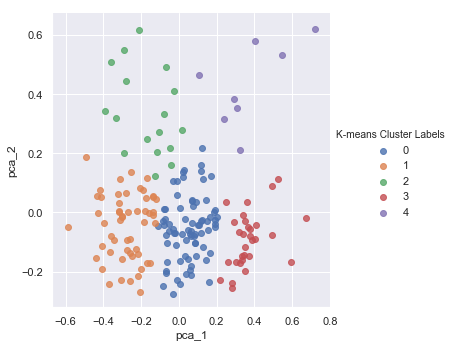

In [10]:
# visualize the group of countries set with the cluster labels displayed
X_pca_frame['K-means Cluster Labels'] = kmeans.labels_
sns.lmplot(x='pca_1', y='pca_2', 
           hue="K-means Cluster Labels", data=X_pca_frame, fit_reg=False)

# save the results in csv file
df_country.to_csv(r'kmeans_cluster.csv', index = False)

## Part2 Regression Code

#### Importing our Dataset

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

df = pd.read_csv("US-predict.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Record number is our index
df.index.name = "record"
print(df.head())
df.tail()

             Date  Covid Cases  Deaths  Unemployment  Laborforce- male  \
record                                                                   
0      2019-11-22          0.0       0        5459.0           86853.0   
1      2019-11-23          0.0       0        5457.0           86854.0   
2      2019-11-24          0.0       0        5454.0           86856.0   
3      2019-11-25          0.0       0        5452.0           86857.0   
4      2019-11-26          0.0       0        5450.0           86858.0   

        Laborforce- female  
record                      
0                  77583.0  
1                  77575.0  
2                  77568.0  
3                  77560.0  
4                  77552.0  


,Date,Covid Cases,Deaths,Unemployment,Laborforce- male,Laborforce- female
record,,,,,,
994,2022-08-12,0.0,0,NaN,NaN,NaN
995,2022-08-13,0.0,0,NaN,NaN,NaN
996,2022-08-14,0.0,0,NaN,NaN,NaN
997,2022-08-15,0.0,0,NaN,NaN,NaN
998,2022-08-16,0.0,0,NaN,NaN,NaN


#### Creating our test & training dataset
Since our original dataset contains a lot of unpredicted values,i.e., future unemployment & laborforce,
the dataset must first be seperated into two different datasets, one tha contains all of our known values,
& one that contains all of our unkown values.

In [53]:
from sklearn.model_selection import train_test_split

# ColY consists of all our dependants.
# ColX consists of our predictors
colY = ['Unemployment', 'Laborforce- male', 'Laborforce- female']
colX = ['Covid Cases','Deaths']

# notnans contains all of our known values, hence we can create a model with this dataset.
known = df[colY].notnull().all(axis=1)
df_known = df[known]

X_train, X_test, y_train, y_test = train_test_split(df_known[colX], df_known[colY],
                                                    train_size=0.75,
                                                    random_state=4)

#### Random Forest Model
For our first model, we've used a Random Forest Regression model.<br>
The model also uses Multi output regression since we're trying to predict more than 3 variables.
We have used Random Forest because:
   * Higher accuracy
   * Better at handling missing values while maintaining accuracy
   * Low bias due to Bagging & Ensembling
    

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# The model
model = MultiOutputRegressor(RandomForestRegressor(random_state=0))

# Fit the training data
model.fit(X_train, y_train)

# Check the prediction score
score = model.score(X_test, y_test)
print("Accuracy of test data is {:.2f}".format(score))

Accuracy of test data is 0.96


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Linear Regression Model
We also created another model based on linear regression

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model_2 = MultiOutputRegressor(LinearRegression())

# Fit on the train data
model_2.fit(X_train, y_train)

# Creating our predictions
y_pred = model_2.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('r2 score is = ' + str(r2))

r2 score is = 0.752743033183752


#### Forecasting with our model
We've used our random forest model for forecasting since it has a better rate of accuracy in comparison to our linear model. <br>
Before we create our predictions, we first create a dataset that consist of all of our unkown variables

In [56]:
df_unk = df.loc[~known].copy()
df_unk[colY] = model.predict(df_unk[colX])

df_unk.tail()

,Date,Covid Cases,Deaths,Unemployment,Laborforce- male,Laborforce- female
record,,,,,,
994,2022-08-12,0.0,0,5628.288833,86603.230542,77467.056994
995,2022-08-13,0.0,0,5628.288833,86603.230542,77467.056994
996,2022-08-14,0.0,0,5628.288833,86603.230542,77467.056994
997,2022-08-15,0.0,0,5628.288833,86603.230542,77467.056994
998,2022-08-16,0.0,0,5628.288833,86603.230542,77467.056994


[Text(0, 0.5, 'Unemployment'), Text(0.5, 0, 'Month & Year')]

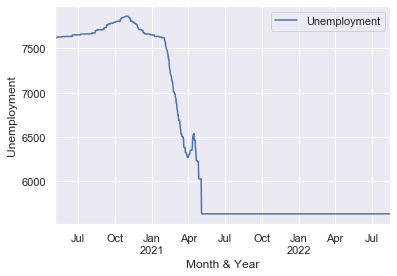

In [57]:
df_unk[['Date','Unemployment']].set_index('Date').plot().set(xlabel ='Month & Year', ylabel ='Unemployment')

[Text(0, 0.5, ' Male Laborforce'), Text(0.5, 0, 'Month & Year')]

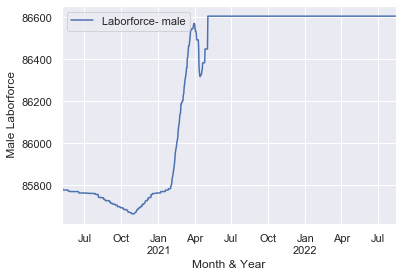

In [58]:
df_unk[['Date','Laborforce- male']].set_index('Date').plot().set(xlabel ='Month & Year', 
                                                                 ylabel =' Male Laborforce')

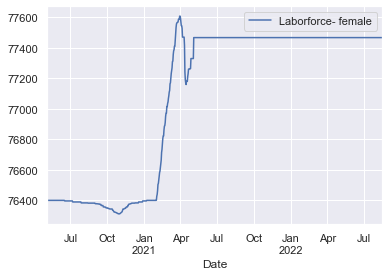

In [59]:
df_unk[['Date','Laborforce- female']].set_index('Date').plot()